# Anti-lock Braking System (ABS)

This example demonstrates an anti-lock braking system (ABS) using nonlinear tire dynamics and event-driven slip control. The system prevents wheel lockup during braking by modulating brake torque to maintain optimal tire-road friction.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_abs_braking.py).

## System Dynamics

The ABS system consists of coupled vehicle and wheel dynamics. The vehicle longitudinal motion is governed by:

$$M \frac{dv}{dt} = -F_x$$

where $M$ is the vehicle mass, $v$ is the vehicle velocity, and $F_x$ is the tire friction force.

The wheel rotational dynamics are described by:

$$J_w \frac{d\omega}{dt} = -T_{brake} + R \cdot F_x$$

where $J_w$ is the wheel inertia, $\omega$ is the wheel angular velocity, $T_{brake}$ is the brake torque, and $R$ is the wheel radius.

## Tire Friction Model

The tire friction force depends on the slip ratio $\lambda$, defined as:

$$\lambda = \frac{v - R\omega}{v}$$

where $\lambda = 0$ represents free rolling (no slip) and $\lambda = 1$ represents locked wheels.

We use the Pacejka "Magic Formula" to model the friction coefficient:

$$\mu(\lambda) = D \sin\left(C \arctan(B\lambda)\right)$$

The friction force is then:

$$F_x = \mu(\lambda) \cdot F_z$$

where $F_z$ is the normal force on the tire. The Pacejka model exhibits a characteristic peak at an optimal slip ratio (typically around 15%), after which friction decreases for higher slip values.

## ABS Control Strategy

The ABS controller uses a bang-bang control strategy with zero-crossing events:

- **Event 1**: When $\lambda > \lambda_{opt} + \delta$, release brake ($T_{brake} = 0$)
- **Event 2**: When $\lambda < \lambda_{opt} - \delta$, apply brake ($T_{brake} = T_{max}$)

where $\lambda_{opt} = 0.15$ is the optimal slip ratio and $\delta = 0.02$ is the control deadband.

## Import and Setup

First let's import the required classes and blocks:

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Integrator, Amplifier, Adder, Function, Scope, Clip, Constant
from pathsim.solvers import RKCK54
from pathsim.events import ZeroCrossing

## Vehicle and Tire Parameters

In [63]:
# Vehicle parameters
M = 1500         # Vehicle mass [kg]
R = 0.3          # Wheel radius [m]
J_w = 1.0        # Wheel rotational inertia [kg·m²]
F_z = M * 9.81 / 4  # Normal force per wheel [N]

# Tire friction model (Pacejka "Magic Formula")
B_coef = 10.0    # Stiffness factor
C_coef = 1.9     # Shape factor
D_coef = 1.0     # Peak friction coefficient

# ABS control parameters
lambda_opt = 0.15      # Optimal slip ratio
abs_threshold = 0.02   # Control band around optimal

# Brake torque
T_brake = 2000   # Maximum brake torque [N·m]

# Initial conditions
v0 = 30          # Initial vehicle speed [m/s]
omega0 = v0 / R  # Initial wheel angular velocity [rad/s]

## Friction and Slip Models

In [66]:
def friction_coefficient(slip):
    """Pacejka tire friction model"""
    return D_coef * np.sin(C_coef * np.arctan(B_coef * slip))

def calculate_slip(v, omega):
    """Calculate slip ratio: lambda = (v - R*omega) / v"""
    omega_actual = max(0, omega)
    if v < 0.1:
        return 0.0
    slip = (v - R * omega_actual) / v
    return np.clip(slip, 0, 1)

def friction_force(slip_ratio):
    """Tire friction force"""
    return friction_coefficient(slip_ratio) * F_z

## System Definition with ABS

Now we construct the vehicle braking system with ABS control:

In [69]:
# ABS control state
abs_state = {'apply_brake': True}

# Wheel dynamics: J_w * domega/dt = -T_brake + R * F_x
omg_raw = Integrator(omega0)
omg_clp = Clip(min_val=0, max_val=1000)
omg_acc = Amplifier(1/J_w)

# Vehicle dynamics: M * dv/dt = -F_x
vel = Integrator(v0)
vel_acc = Amplifier(-1/M)

# Slip and friction
slp = Function(calculate_slip)
frc = Function(friction_force)
frc_cof = Function(friction_coefficient)

# ABS control
brk = Constant(T_brake)  # Will be modulated by events
brk_neg = Amplifier(-1)

# Torque summation
whl_trq = Amplifier(R)
trq_sum = Adder("++")

# Measurement
whl_vel = Amplifier(R)
sco1 = Scope(labels=["Vehicle Speed [m/s]", "Wheel Speed [m/s]"])
sco2 = Scope(labels=["Slip Ratio", "Friction Coeff"])

blocks = [
    omg_raw, omg_clp, omg_acc, vel, vel_acc,
    slp, frc, frc_cof, brk, brk_neg,
    whl_trq, trq_sum, whl_vel, sco1, sco2
]

In [71]:
connections = [
    # Wheel dynamics
    Connection(omg_acc, omg_raw),
    Connection(omg_raw, omg_clp),
    Connection(omg_clp, whl_vel),
    Connection(trq_sum, omg_acc),

    # Vehicle dynamics
    Connection(vel_acc, vel),
    Connection(vel, sco1[0]),

    # Slip calculation
    Connection(vel, slp[0]),
    Connection(omg_clp, slp[1]),
    Connection(slp, sco2[0]),

    # Friction
    Connection(slp, frc),
    Connection(frc, whl_trq, vel_acc),
    Connection(slp, frc_cof),
    Connection(frc_cof, sco2[1]),

    # Brake control (ABS with events)
    Connection(brk, brk_neg),
    Connection(brk_neg, trq_sum[1]),

    # Torque balance
    Connection(whl_trq, trq_sum[0]),
    Connection(whl_vel, sco1[1]),
]

## ABS Control Events

In [74]:
# Event: slip too high -> release brake
def evt_slip_high(t):
    """Detects when slip exceeds upper threshold"""
    slip_val = slp.outputs[0]
    return slip_val - (lambda_opt + abs_threshold)

def act_release_brake(t):
    """Release brake when slip is too high"""
    abs_state['apply_brake'] = False
    brk.value = 0

evt_high = ZeroCrossing(func_evt=evt_slip_high, func_act=act_release_brake, tolerance=1e-4)

# Event: slip too low -> apply brake
def evt_slip_low(t):
    """Detects when slip falls below lower threshold"""
    slip_val = slp.outputs[0]
    return (lambda_opt - abs_threshold) - slip_val

def act_apply_brake(t):
    """Apply brake when slip is too low"""
    abs_state['apply_brake'] = True
    brk.value = T_brake

evt_low = ZeroCrossing(func_evt=evt_slip_low, func_act=act_apply_brake, tolerance=1e-4)

events = [evt_high, evt_low]

## Simulation with ABS

In [77]:
# Simulation initialization
Sim_ABS = Simulation(blocks, connections, events, Solver=RKCK54)

# Run simulation for 5 seconds
Sim_ABS.run(5)

2025-11-02 15:48:23,422 - INFO - LOGGING (log: True)
2025-11-02 15:48:23,422 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-11-02 15:48:23,422 - INFO - BLOCK (type: Clip, dynamic: False, events: 0)
2025-11-02 15:48:23,423 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:23,423 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-11-02 15:48:23,423 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:23,423 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:23,424 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:23,424 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:23,424 - INFO - BLOCK (type: Constant, dynamic: False, events: 0)
2025-11-02 15:48:23,425 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:23,425 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:23,426 - INFO -

{'total_steps': 20077,
 'successful_steps': 13028,
 'runtime_ms': 7057.173200009856}

## Comparison: System without ABS

To demonstrate the effectiveness of ABS, let's simulate the same scenario without ABS control (constant maximum braking):

In [80]:
# System without ABS - constant brake torque
omg_raw_noabs = Integrator(omega0)
omg_clp_noabs = Clip(min_val=0, max_val=1000)
omg_acc_noabs = Amplifier(1/J_w)

vel_noabs = Integrator(v0)
vel_acc_noabs = Amplifier(-1/M)

slp_noabs = Function(calculate_slip)
frc_noabs = Function(friction_force)
frc_cof_noabs = Function(friction_coefficient)

brk_noabs = Constant(T_brake)  # Constant brake torque (no ABS)
brk_neg_noabs = Amplifier(-1)

whl_trq_noabs = Amplifier(R)
trq_sum_noabs = Adder("++")
whl_vel_noabs = Amplifier(R)

sco1_noabs = Scope(labels=["Vehicle Speed [m/s]", "Wheel Speed [m/s]"])
sco2_noabs = Scope(labels=["Slip Ratio", "Friction Coeff"])

blocks_noabs = [
    omg_raw_noabs, omg_clp_noabs, omg_acc_noabs, vel_noabs, vel_acc_noabs,
    slp_noabs, frc_noabs, frc_cof_noabs, brk_noabs, brk_neg_noabs,
    whl_trq_noabs, trq_sum_noabs, whl_vel_noabs, sco1_noabs, sco2_noabs
]

connections_noabs = [
    Connection(omg_acc_noabs, omg_raw_noabs),
    Connection(omg_raw_noabs, omg_clp_noabs),
    Connection(omg_clp_noabs, whl_vel_noabs),
    Connection(trq_sum_noabs, omg_acc_noabs),
    Connection(vel_acc_noabs, vel_noabs),
    Connection(vel_noabs, sco1_noabs[0]),
    Connection(vel_noabs, slp_noabs[0]),
    Connection(omg_clp_noabs, slp_noabs[1]),
    Connection(slp_noabs, sco2_noabs[0]),
    Connection(slp_noabs, frc_noabs),
    Connection(frc_noabs, whl_trq_noabs, vel_acc_noabs),
    Connection(slp_noabs, frc_cof_noabs),
    Connection(frc_cof_noabs, sco2_noabs[1]),
    Connection(brk_noabs, brk_neg_noabs),
    Connection(brk_neg_noabs, trq_sum_noabs[1]),
    Connection(whl_trq_noabs, trq_sum_noabs[0]),
    Connection(whl_vel_noabs, sco1_noabs[1]),
]

# Simulation without ABS
Sim_NoABS = Simulation(blocks_noabs, connections_noabs, Solver=RKCK54, dt=0.001)
Sim_NoABS.run(5)

2025-11-02 15:48:37,690 - INFO - LOGGING (log: True)
2025-11-02 15:48:37,691 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-11-02 15:48:37,691 - INFO - BLOCK (type: Clip, dynamic: False, events: 0)
2025-11-02 15:48:37,691 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:37,692 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-11-02 15:48:37,692 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:37,692 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:37,692 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:37,693 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-11-02 15:48:37,693 - INFO - BLOCK (type: Constant, dynamic: False, events: 0)
2025-11-02 15:48:37,694 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:37,694 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:48:37,694 - INFO -

{'total_steps': 31, 'successful_steps': 15, 'runtime_ms': 12.189600005513057}

## Results and Comparison

Let's plot and compare both scenarios:

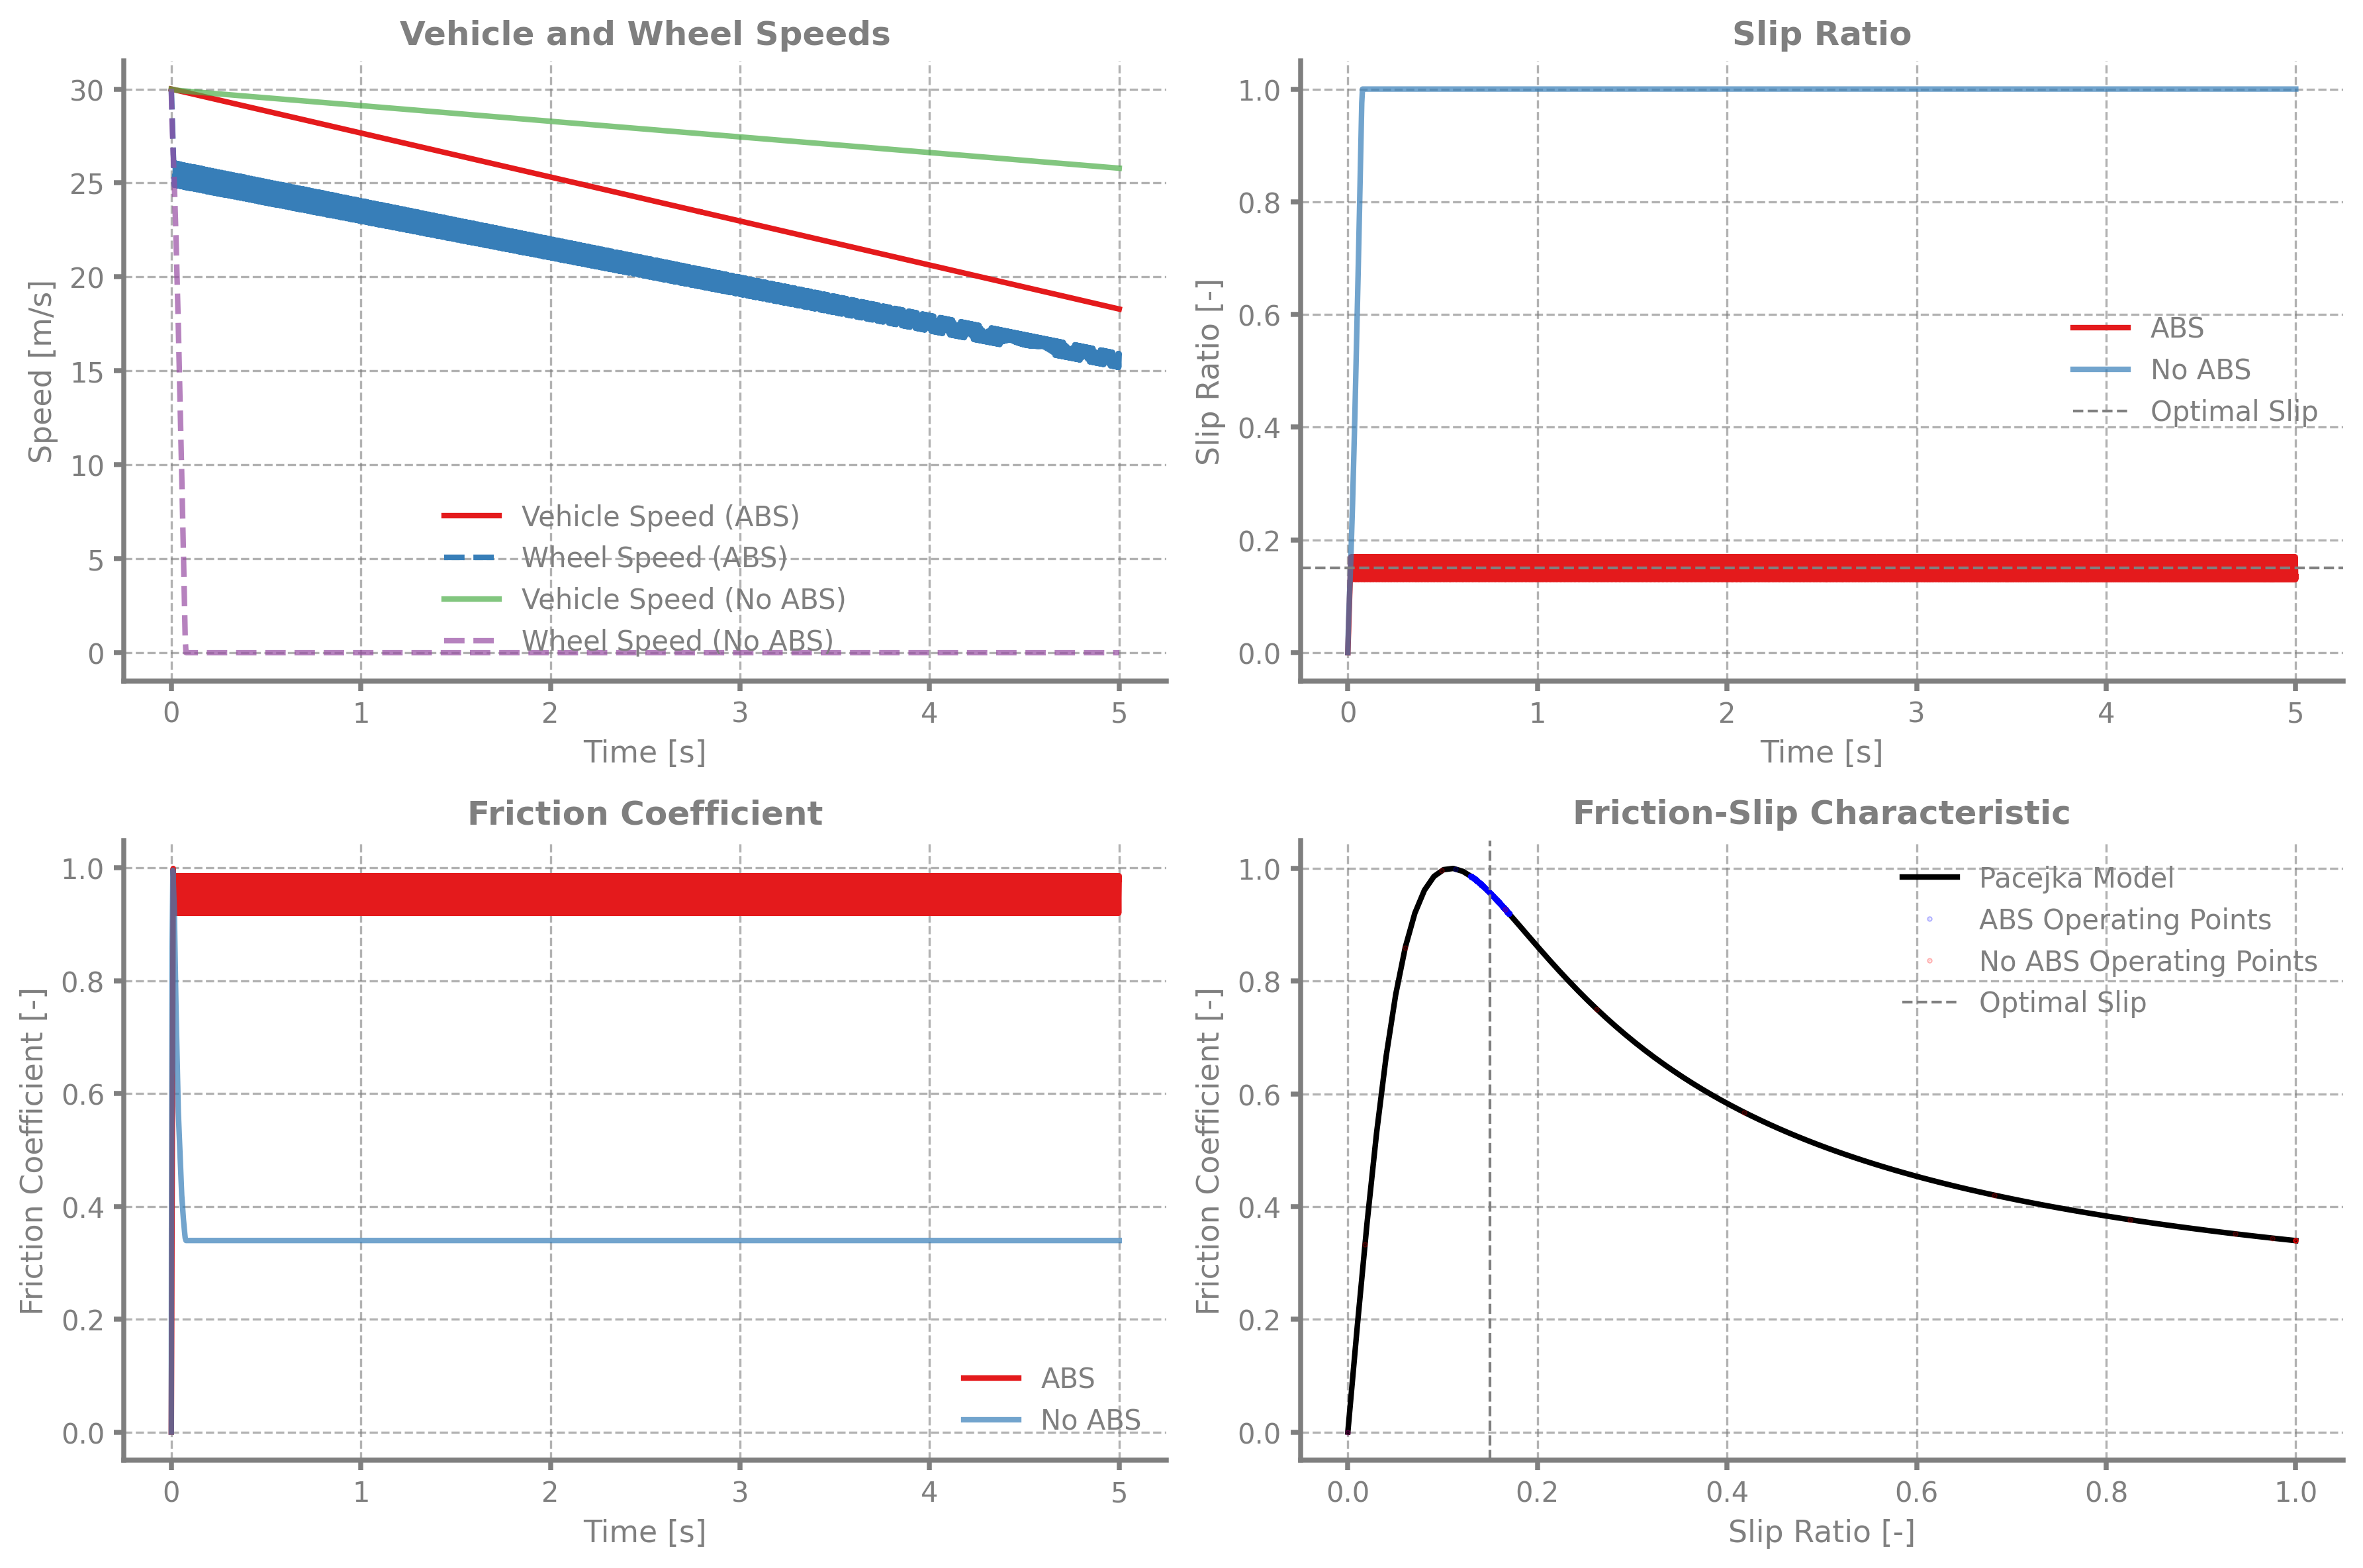

In [83]:
# Read data from both simulations
t_abs, [v_abs, w_abs] = sco1.read()
t_abs2, [slip_abs, mu_abs] = sco2.read()
t_noabs, [v_noabs, w_noabs] = sco1_noabs.read()
t_noabs2, [slip_noabs, mu_noabs] = sco2_noabs.read()

# Create comparison plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# Vehicle and wheel speeds
axs[0, 0].plot(t_abs, v_abs, label="Vehicle Speed (ABS)", lw=2)
axs[0, 0].plot(t_abs, w_abs, label="Wheel Speed (ABS)", lw=2, ls="--")
axs[0, 0].plot(t_noabs, v_noabs, label="Vehicle Speed (No ABS)", lw=2, alpha=0.7)
axs[0, 0].plot(t_noabs, w_noabs, label="Wheel Speed (No ABS)", lw=2, ls="--", alpha=0.7)
axs[0, 0].set_xlabel("Time [s]")
axs[0, 0].set_ylabel("Speed [m/s]")
axs[0, 0].set_title("Vehicle and Wheel Speeds")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Slip ratio comparison
axs[0, 1].plot(t_abs2, slip_abs, label="ABS", lw=2)
axs[0, 1].plot(t_noabs2, slip_noabs, label="No ABS", lw=2, alpha=0.7)
axs[0, 1].axhline(lambda_opt, ls="--", c="gray", lw=1, label="Optimal Slip")
axs[0, 1].set_xlabel("Time [s]")
axs[0, 1].set_ylabel("Slip Ratio [-]")
axs[0, 1].set_title("Slip Ratio")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Friction coefficient
axs[1, 0].plot(t_abs2, mu_abs, label="ABS", lw=2)
axs[1, 0].plot(t_noabs2, mu_noabs, label="No ABS", lw=2, alpha=0.7)
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].set_ylabel("Friction Coefficient [-]")
axs[1, 0].set_title("Friction Coefficient")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Friction vs slip characteristic with operating points
slip_range = np.linspace(0, 1, 100)
mu_range = friction_coefficient(slip_range)
axs[1, 1].plot(slip_range, mu_range, 'k-', lw=2, label="Pacejka Model")
axs[1, 1].plot(slip_abs, mu_abs, 'b.', ms=1, alpha=0.3, label="ABS Operating Points")
axs[1, 1].plot(slip_noabs, mu_noabs, 'r.', ms=1, alpha=0.3, label="No ABS Operating Points")
axs[1, 1].axvline(lambda_opt, ls="--", c="gray", lw=1, label="Optimal Slip")
axs[1, 1].set_xlabel("Slip Ratio [-]")
axs[1, 1].set_ylabel("Friction Coefficient [-]")
axs[1, 1].set_title("Friction-Slip Characteristic")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.show()

## Analysis

The results demonstrate the effectiveness of ABS:

**With ABS:**
- **Slip control**: System maintains slip ratio near optimal value (0.15) through event-driven brake modulation
- **Wheel speed**: Wheels continue rotating (no lockup), maintaining steering control
- **Friction utilization**: ABS keeps friction coefficient near peak value (~1.0) throughout braking
- **Braking efficiency**: Optimal slip control provides maximum deceleration

**Without ABS:**
- **Wheel lockup**: Wheels lock immediately (wheel speed drops to zero)
- **Slip saturation**: Slip ratio quickly reaches 1.0 (complete lockup)
- **Reduced friction**: Friction coefficient drops significantly below peak value
- **Longer stopping distance**: Reduced friction leads to increased braking distance
- **Loss of control**: Locked wheels prevent steering corrections

The friction-slip characteristic plot clearly shows how ABS maintains operation near the peak friction region, while constant braking quickly pushes the system into the unstable high-slip region where friction degrades.


This example demonstrates PathSim's capability to model complex multi-domain systems with event-driven control, combining:

- Nonlinear multi-body dynamics (vehicle-wheel coupling)
- Nonlinear tire friction characteristics (Pacejka model)
- Zero-crossing event detection for precise control switching
- Physical constraints (preventing negative wheel speeds)
- Comparative analysis between controlled and uncontrolled systems